# Identificar la Arquitectura


 El rendimiento SIMD, va a depender de que instrucciones y tipos de datos
  están disponibles. Por tanto lo pimero es verificar el modelo de CPU que estamos usando.

In [ ]:
# En Linux
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4400.42
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

In [ ]:
# Identifciar el modelo de CPU y la frecuencia
!cat /proc/cpuinfo | grep "model name" | head -1

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


### Instrucciones SIMD

Extensiones al conjunto de instrucciones SIMD son en Intel [SSE](https://en.wikipedia.org/wiki/Streaming_SIMD_Extensions) y [AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions), en ARM [Neon](https://en.wikipedia.org/wiki/ARM_architecture#Advanced_SIMD_(NEON)) y en AMD [3DNow!](https://en.wikipedia.org/wiki/3DNow!).

Concretamente en el caso de la CPU de esta arquitectura podemos identificarlo en los flags de compilación que admite.

In [ ]:
!cat /proc/cpuinfo | grep "flags" | head -1

flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities


El conjunto de instrucciones SIMD más potente admitido depende del flag disponible, asi por ejemplo si aparece avx512f es set de instrucciones  es AVX-512, que amplía AVX para admitir la ejecución de SIMD en datos de 512 bits de ancho, y es capaz de realizar 16 operaciones float32 u 8 operaciones float64 cada vez.

También conviene identificar el número de procesadores y si está activado el hyperthreading ( siblings), aunque no sea significativo para SIMD.

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.212
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4400.42
clflush size	: 64
cache_alignment	: 64
ad

### Sistema de memoria
Para el rendimiento global es imprescindible entender el efecto des sistema de memoria.
Otro componente que afecta significativamente el rendimiento es el subsistema de memoria. El tamaño de la memoria es una de las especificaciones clave de un sistema. Por tanto hay que ver la memoria de la máquina que estamos utilizando.

In [ ]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       13290460 kB


In [ ]:
!lscpu | grep cache

L1d cache:                            32 KiB (1 instance)
L1i cache:                            32 KiB (1 instance)
L2 cache:                             256 KiB (1 instance)
L3 cache:                             55 MiB (1 instance)


Como puede verse, existen tres niveles de cachés: L1, L2 y L3 (o LLC, Last Level Cache). La caché L1 tiene 32 KB para instrucciones y 32 KB para datos. La caché L2 es 8 veces más grande. La caché L3 es mucho más grande, pero sigue siendo miles de veces más pequeña que la memoria principal. Los beneficios de los cachés son una latencia de acceso y un ancho de banda significativamente mejorados. Normalmente en las CPU modernas,
la latencia para acceder a la caché L1 es inferior a 1 ns, la latencia de la caché L2 es de alrededor de 7 ns y la caché L3 es más lenta, con una latencia de aproximadamente 20 ns, aunque sigue siendo más rápida que la latencia de 100 ns de la memoria principal.
![El diseño de la memoria principal y los cachés.](http://tvm.d2l.ai/_images/cpu_memory.svg)
:etiqueta:`fig_cpu_memory`

En :numref:`fig_cpu_memory` se ilustra un breve diseño del subsistema de memoria.
Las cachés L1 y L2 son exclusivas de cada núcleo de CPU y la caché L3 se comparte entre los núcleos del mismo procesador de CPU.
Para procesar algunos datos, una CPU primero verificará si los datos existen en la caché L1, si no, verificará la caché L2, si no, verificará la caché L3, si no, irá a la memoria principal para recuperar los datos y llevarlos hasta L3. caché, caché L2 y caché L1, finalmente a los registros de la CPU.
Esto parece muy costoso pero, afortunadamente, en la práctica, los programas tienen [patrones de localidad de datos](https://en.wikipedia.org/wiki/Locality_of_reference) que acelerarán el procedimiento de recuperación de datos. Hay dos tipos de localidad: localidad temporal y localidad espacial.
Localidad temporal significa que los datos que acabamos de usar normalmente se usarán en un futuro cercano, por lo que aún pueden estar en el caché. La localidad espacial significa que es probable que los datos adyacentes a los que acabamos de usar se utilicen en un futuro próximo. Como el sistema siempre trae un bloque de valores al caché cada vez (consulte el concepto de [líneas de caché](https://en.wikipedia.org/wiki/CPU_cache#CACHE-LINES)), esos datos adyacentes pueden aún estar en caché cuando se hace referencia a él.
Aprovechar la ventaja que aporta la localidad de los datos es uno de los principios de optimización del rendimiento más importantes.

## Cómo conseguir el mejor rendimiento

- Las CPU tienen unidades dedicadas para manejar cálculos sobre varios tipos de datos. El rendimiento máximo de una CPU está determinado por la velocidad del reloj, la cantidad de núcleos y los conjuntos de instrucciones.
- Las CPU utilizan cachés de varios niveles para cerrar la brecha entre la potencia computacional de la CPU y el ancho de banda de la memoria principal.
- Un programa eficiente debe estar efectivamente paralelizado y acceder a datos con buenas localidades temporales y espaciales.



# SIMD: Instrucciones SSE y AVX

Se puede encontrar una descripción completa de las instrucciones SSE y AVX en el enlace: https://software.intel.com/sites/landingpage/IntrinsicsGuide/

Como referencia indicar que cualquier CPU producida después de 2000 admite SSE hasta 4.2.

AVX y especialmente AVX2 son tecnologías más recientes; consulte Wikipedia para obtener una lista de procesadores compatibles: https://en.wikipedia.org/wiki/Advanced_Vector_Extensions



Antes de empezar con las funciones intrínsecas relacionadas con las matemáticas proporcionadas por AVX y AVX2 es importante entender los siguiente puntos:

* Tipos de datos
* Convenciones de nomenclatura de funciones


## Tipos de datos SIMD

Algunos *intrinsics* aceptan tipos de datos tradicionales como ints o floats, pero la mayoría opera con tipos de datos que son específicos de AVX y AVX2.
Hay seis tipos de vectores principales enumarados en la Tabla 1

### Tabla 1: Tipos de datos AVX/AVX2
Type        |  Explanation
------------|-------------------------------------
__m128      | vector de 128-bit que contiene 4 floats
__m128d	    | vector de 128-bit que contiene 2 doubles
__m128i	    | vector de 128-bit que contiene integers
__m256	    | vector de 256-bit que contiene 8 floats
__m256d	    | vector de 256-bit que contiene 4 doubles​
__m256i	    | vector de 256-bit que contiene integers

Cada tipo comienza con dos guiones bajos, una m y el ancho del vector en bits. AVX512 admite tipos de vectores de 512 bits que comienzan con _m512, pero los vectores AVX/AVX2 no superan los 256 bits.

Si un tipo de vector termina en d, contiene *doubles* y si no tiene sufijo, contiene *floats*. Puede parecer que los vectores _m128i y _m256i deben contener enteros, pero no es así. Un tipo de vector entero puede contener cualquier tipo de número entero, desde *chars* hasta *shorts* y *longs* sin signo. Es decir, un _m256i puede contener 32 *chars*, 16 *shorts*, 8 *ints*, or 4 *longs*. Estos números enteros pueden tener o no signo.



## Convención de nombres de funciones

Los nombres de los *intrinsics* AVX/AVX2 pueden resultar confusos al principio, pero la convención de nomenclatura es realmente sencilla. Una función intrínseca genérica de AVX/AVX2 se proporciona de la siguiente manera:

_mm\<bit_width>_\<nombre>_\<tipo_datos>

Las partes de este formato se interpretan de la siguiente manera:

* \<bit_width> identifica el tamaño del vector devuelto por la función. Para vectores de 128 bits, está vacío. Para vectores de 256 bits, se establece en 256.
* \<nombre> describe la operación realizada por el intrínseco
* \<tipo_datos> identifica el tipo de datos de los argumentos principales de la función. Esta última parte, \<tipo_datos>, es un poco complicada. Identifica el contenido de los valores de entrada y se puede establecer en cualquiera de los siguientes valores:
** ps - vector contiene floats (ps indica packed single-precision)
** pd - vector contiene doubles (pd indica packed double-precision)
** epi8/epi16/epi32/epi64 - vector contiene 8-bit/16-bit/32-bit/64-bit enteros con signo
** epu8/epu16/epu32/epu64 - vector continene 8-bit/16-bit/32-bit/64-bit * enteros sin signo
** si128/si256 - vector de 128-bit sin esecificar o vector de 256-bit
** m128/m128i/m128d/m256/m256i/m256d - identifica los tipos de vectores de entrada cuando son diferentes al tipo del vector devuelto

## Ejercicios

### Ejercicio 1.1

Considere la función  **_mm256_srlv_epi64**. Incluso si no sabe lo que significa srlv, ¿Qué se puede decir de la salida y de los argumentos de entrada de la función?



### Ejercicio 1.2

Considere la función **_mm_testnzc_ps**. Incluso si no sabe lo que significa testnzc, ¿Qué se puede decir de la salida y de los argumentos de entrada de la función?



##  Ejemplo que utiliza AVX Intrinsic

Para crear una aplicación que utilice elementos intrínsecos de AVX, no es necesario vincular ninguna biblioteca. Pero se debe incluir el archivo de encabezado immintrin.h. Este encabezado incluye otros encabezados que asignan funciones AVX/AVX2 a instrucciones.

In [16]:
%%writefile parimpar.c
#include <immintrin.h>
#include <stdio.h>

int main() {

  /* Initialize the two argument vectors */
  __m256 evens = _mm256_set_ps(2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0);
  __m256 odds = _mm256_set_ps(1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0);

  /* Compute the difference between the two vectors */
  __m256 result = _mm256_sub_ps(evens, odds);

  /* Display the elements of the result vector */
  float* f = (float*)&result;
  printf("%f %f %f %f %f %f %f %f\n",
    f[0], f[1], f[2], f[3], f[4], f[5], f[6], f[7]);

  return 0;
}

Writing parimpar.c


Para crear la aplicación, debe decirle al compilador que la arquitectura es compatible con AVX. El indicador depende del compilador y gcc requiere el indicador -mavx. Por lo tanto, el archivo fuente hello_avx.c se puede compilar con el siguiente comando:


In [17]:
!gcc parimpar.c -mavx -o parimpar

In [ ]:
! ./parimpar

otra forma de compilar si sabemos que la arquitectura admite avx es indicar que se compile para la arquitectura nativa con -march=native  y además no conviene olvidar que queremos incluir el nivel de optimización máximo -O3

In [19]:
!gcc parimpar.c -O3  -march=native -fwhole-program -Wall -D_GNU_SOURCE -o parimparO3

In [ ]:
! ./parimparO3

## Alineacion de datos en memoria: SIMD Acceso a datos

Las operaciones SIMD procesan datos según el principio de “múltiples datos = múltiples datos + múltiples datos”. Esto significa que las operaciones SIMD pueden procesar una mayor cantidad de datos por instrucción que las operaciones escalares, lo que permite reducir el número de instrucciones necesarias a ejecutar y, por tanto, el tiempo necesario para su procesamiento.

Para que el rendimiento no se vea penalizado por el acceso a memoria, es conveniente que el acceso a los datos sea lo más eficiente posible, y esto se consigue con datos alineados en memoria.

  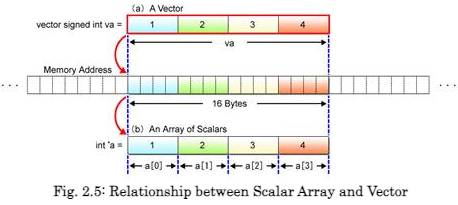

Por ejemplo si realizamos operaciones con vectores de enteros de 32 bit, se puede conseguir almacenarlos en memoria alineados en fronteras de 32 Bytes ( 32-byte aligned) y facilitar su acceso cuando se guarden en registros de 128 bits. Para que estén alineados en 32 bytes, en la reserva de memoria se utiliza el atributo aligned y la palabra clave attribute.

En el archivo de encabezado emmintrin.h se define un conjunto de tipos de datos que representan diferentes tipos de vectores. Entre otros:

 * __m128: Define un vector de cuatro números de punto flotante (4x32 = 128 bits)
 * __m128d: Define un vector de dos números de doble precisión (2x64 = 128 bits.
 * __m128i: Define un vector de cuatro números enteros de 32 bitsn (4x32 = 128 bits.

Se definen varias funciones que operan en vectores __m128:
 * _mm_add_epi32(__m128i a, __m128i b): Esto devuelve un vector __m128i donde cada uno de los cuatro elementos es igual a la suma de a y b, es decir, [a[0]+b[0], a[1]+b[ 1], a[2]+b[2], a[3]+b[3]
 * _mm_add_ps(__m128 a, __m128 b): Esto devuelve un vector __m128 donde cada uno de los cuatro elementos es igual a la suma de a y b, es decir, [a[0]+b[0], a[1]+b[ 1], a[2]+b[2], a[3]+b[3]

In [33]:
%%writefile alignedvec_add.c
/*  FILE: alignedvec_add.c */

#include <stdio.h>
#include <emmintrin.h>

// declares input/output scalar variables 32-bytes aligned

int a[4] __attribute__((aligned(32))) = { 1, 3, 5, 7 };
int b[4] __attribute__((aligned(32))) = { 2, 4, 6, 8 };
int c[8] __attribute__((aligned(32)));

int d[4] __attribute__((aligned(32))) = { 11, 13, 15, 17 };
int e[4] __attribute__((aligned(32))) = { 12, 14, 16, 18 };

int main(int argc, char **argv)
{
    // declares vector variables which points to scalar arrays

    __m128i *va = (__m128i *) a;
    __m128i *vb = (__m128i *) b;
    __m128i *vc = (__m128i *) c;

    // adds four signed intergers at once
    vc[0] = _mm_add_epi32(va[0],vb[0]);    // 1 + 2, 3 + 4, 5 + 6, 7 + 8

    va = (__m128i *) d;
    vb = (__m128i *) e;

    // adds four signed intergers at once
    vc[1] = _mm_add_epi32(va[0],vb[0]);    // 11+12, 13+14, 15+16, 17+18

    //output results
    printf("c[0]=%d, c[1]=%d, c[2]=%d, c[3]=%d\n", c[0], c[1], c[2], c[3]);
    printf("c[4]=%d, c[5]=%d, c[6]=%d, c[7]=%d\n", c[4], c[5], c[6], c[7]);

    return 0;
}

Writing alignedvec_add.c


In [34]:
!gcc alignedvec_add.c -o alignedvec_add

In [35]:
! ./alignedvec_add

c[0]=3, c[1]=7, c[2]=11, c[3]=15
c[4]=23, c[5]=27, c[6]=31, c[7]=35


Actualmente se ha mejorado la situación :
* Las instrucciones SSE requieren operandos de memoria alineados, excepto las instrucciones que dicen no alineados
* Las instrucciones AVX no requieren operandos de memoria alineados, excepto las instrucciones que dicen alineados

IMPORTANTE Si se desea declarar matrices de floats y tratarlos como objetos __m128 mediante conversión, debe asegurarse de que las matrices de floats estén alineadas correctamente:

* usar __attribute__((aligned(32))) en gcc
* usar __declspec(align(32)) en windows



## Registros SIMD

Registros vectoriales en aquitectura x86-64 con soporte AVX512

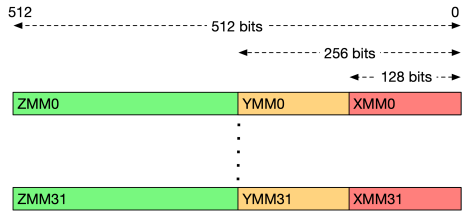

En las primeras generaciones SSE y SSE2 los registros vectoriales son de 128 bit.

Figura SIMD registros
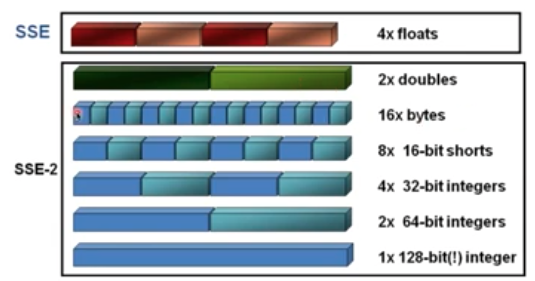

### Ejercicios

* E1.3 En un registro SIMD de 128 bit, ¿Cuántos enteros se pueden almacenar?
* E1.4 En un registro SIMD de 128 bit, ¿Cuántos números reales de precisión simple (float) se pueden almacenar?
* E1.5 En un registro SIMD de 128 bit, ¿Cuántos números reales de doble precisión (double) se pueden almacenar?

### Ejercicios registros SIMD

En un procesador con extensiones SIMD se utilizan registros de 2048 bits.
* E1.6 ¿Cuántos números reales de doble precisión pueden almacenar?
* E1.7 ¿Cuántos carácteres se pueden almacenar?
* E1.8  ¿Cuántos *pixeles* se pueden almacenar? ( un pixel son 3 bytes para almacenar rojo-verde y azul)


### Ejercicios registros YMM
Los registros YMM son de 256 bits

* E1.9 ¿Cuantos enteros se pueden almacenar en un registro YMM?

* E1.10 Suponga un vector de 32 doubles, ( double vest[32]), ¿ Cuantos registros se necesitan para procesarlo utilizanco instrucciones SIMD?

## Evaluar tamaño del problema a resolver en función de la capacidad de memoria y su jerarquía

### Elegir distinto tamaños de vector cumpliendo_
* Supere el tamaño de de L1d
* Supere el tamaño de L2
* Supere el tamaño de L3
y con tamaños multiplos del número de elementos SIMD a procesar y cuando no lo sean-

In [12]:
!lscpu | grep cache

L1d cache:                            32 KiB (1 instance)
L1i cache:                            32 KiB (1 instance)
L2 cache:                             256 KiB (1 instance)
L3 cache:                             55 MiB (1 instance)


In [13]:
tam0 = 8*1024
tam1 = 8*1024-1
tam2 = 16*1024
tam3 = 16*1024-1
tam_L1d = 32768
tam_L1di = 32765
tam6= 131072
tam7= 131070
tam_L2 = 262144
tam_L2i = 262141
tam10 = 512215
tam11 = 512212

tam = [ tam0, tam1, tam2, tam3, tam_L1d, tam_L1di, tam6, tam7, tam_L2, tam_L2i, tam10, tam11]

for i in tam:
  print(i)

8192
8191
16384
16383
32768
32765
131072
131070
262144
262141
512215
512212


## Evaluar el resultado de las opciones de compilación

El compilador transforma el código fuente  en un binario legible por máquina. Este paso es necesario para ejecutar el código en una CPU. Además de traducir el código fuente a binario, el compilador también puede optimizar el código para reducir el tiempo de ejecución y el consumo de energía.
Para lograr esto, el compilador proporciona opciones de optimización. Los más conocidos empiezan por -O y definen un nivel de optimización global:
- O0 Sin optimización,
- O1 Habilita una serie de optimizaciones para reducir el tamaño binario y el tiempo de ejecución, mientras mantiene el tiempo de compilación relativamente bajo.
- O2 Permite todas las optimizaciones posibles (excepto aquellas que requieren un compromiso entre eficiencia y
tamaño binario), esta opción requiere un tiempo de compilación más largo que -O1,
- O3 Permite todas las optimizaciones posibles que no comprometan la precisión del cálculo ni el tiempo de compilación.
aumenta en comparación con -O2.

Estos diferentes niveles de optimización son válidos para compiladores GNU (gcc) y compiladores Clang. Pueden variar
según el compilador que utilices, por lo que es responsabilidad del desarrollador familiarizarse con su compilador.
Para obtener más detalles sobre las distintas optimizaciones del compilador, visita https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html

##Ejemplo: Producto escalar de dos vectores con elementos reales (double)

La compilación del código SIMD por defecto se realiza con
CFLAGS := -O3 -march=native

Consulta el funcionamiento de las funciones utilizadas en el código que se proporciona de ejemplo en el [enlace https://software.intel.com/sites/landingpage/IntrinsicsGuide/](https://software.intel.com/sites/landingpage/IntrinsicsGuide/ )

Concretamente, las funciones utilizadas son:
En el producto elemento a elemento de los vectores:

* __m256d x = _mm256_load_pd(a+4*ii);
*    __m256d y = _mm256_load_pd(b+4*ii);
*    __m256d z = _mm256_mul_pd(x,y);
*    sum_vec = _mm256_add_pd(sum_vec, z);

En la reducción del vector:


*   __m256d temp = (__m256d) _mm256_hadd_pd(input, input);
*   __m256d temp = _mm256_hadd_pd(input, input);
* __m128d sum_high = _mm256_extractf128_pd(temp, 1);
*  __m128d result = _mm_add_pd(sum_high, _mm256_castpd256_pd128(temp));



In [29]:
%%writefile exdot_product.c
/* Compute the dot product of two (properly aligned) vectors. */
/* Limitado a tamaños reserva mem de 512215x8xbytesx2 (aprox 8 MBytes) */

#define MAX_ITER 5
#define MAX_N 512215
#define NUM_TAM 12

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <sys/time.h>
#include <immintrin.h>

double slow_dot_product(const double *a, const double *b, int num_elem) {
  double answer = 0.0;
  for(int ii = 0; ii < num_elem; ++ii)
    answer += a[ii]*b[ii];
  return answer;
}

double reverse_slow_dot_product(const double *a, const double *b, int num_elem) {
  double rev_answer = 0.0;
  for(int ii = 0; ii < num_elem; ++ii)
    rev_answer += a[num_elem-ii-1]*b[num_elem-ii-1];
  return rev_answer;
}

/* Horizontal add works within 128-bit lanes. Use scalar ops to add
 * across the boundary. */
double reduce_vector1(__m256d input) {
  __m256d temp = (__m256d) _mm256_hadd_pd(input, input);
  return ((double*)&temp)[0] + ((double*)&temp)[2];
}

/* Another way to get around the 128-bit boundary: grab the first 128
 * bits, grab the lower 128 bits and then add them together with a 128
 * bit add instruction. */
double reduce_vector2(__m256d input) {
  __m256d temp = _mm256_hadd_pd(input, input);
  __m128d sum_high = _mm256_extractf128_pd(temp, 1);
  __m128d result = _mm_add_pd(sum_high, _mm256_castpd256_pd128(temp));
  return ((double*)&result)[0];
}

double dot_product(const double *a, const double *b, int num_elem) {
  __m256d sum_vec = _mm256_set_pd(0.0, 0.0, 0.0, 0.0);

  /* Add up partial dot-products in blocks of 256 bits */
  for(int ii = 0; ii < num_elem/4; ++ii) {
    __m256d x = _mm256_load_pd(a+4*ii);
    __m256d y = _mm256_load_pd(b+4*ii);
    __m256d z = _mm256_mul_pd(x,y);
    sum_vec = _mm256_add_pd(sum_vec, z);
  }

  /* Find the partial dot-product for the remaining elements after
   * dealing with all 256-bit blocks. */
  double final = 0.0;
  for(int ii = num_elem-num_elem%4; ii < num_elem; ++ii)
    final += a[ii] * b[ii];

  return reduce_vector2(sum_vec) + final;
}


int main(int argc, char **argv) {

  __attribute__ ((aligned (32))) double a[MAX_N], b[MAX_N];
    struct timeval fin,ini;
  long int tiempo[MAX_ITER],tiempodot[MAX_ITER];
  double answer[MAX_ITER], answerdot[MAX_ITER], rev_answerdot[MAX_ITER];;
  float acel;

  int tam[NUM_TAM];

  int tam0 = 8191; tam[0]=tam0;
  int tam1 = 8192; tam[1]=tam1;
  int tam2 = 16383; tam[2]=tam2;
  int tam3 = 16384; tam[3]=tam3;
  int tam_L1d = 32768; tam[4]=tam_L1d;
  int tam_L1di = 32765; tam[5]=tam_L1di;
  int tam6= 131072; tam[6]=tam6;
  int tam7= 131070; tam[7]=tam7;
  int tam_L2 = 262144; tam[8]=tam_L2;
  int tam_L2i = 262141; tam[9]=tam_L2i;
  int tam10 = 512215; tam[10]=tam10;
  int tam11 = 512212; tam[11]=tam11;


   int N = MAX_N;
  // asignación de valores
  for(int ii = 0; ii < N; ++ii){
    a[ii] = b[ii] = ii/sqrt(N);
    }
  // tamaños de vector
  for( int k=0 ; k<NUM_TAM; k++) {                  // VECTORES DE DISTINTOS TAMAÑOS
    N=tam[k];
    printf(" tamaño de vector N = %d \n", N);
    for (int iter=0; iter< MAX_ITER; iter++){   //ITERACIONES
      //producto SIMD
      gettimeofday(&ini,NULL);
      answer[iter] = dot_product(a, b, N);
      gettimeofday(&fin,NULL);
      tiempo[iter]=(fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec);
      printf("iter = %d ,resultado SIMD =%f y tiempo SIMD: %ld us. \n", iter, answer[iter], tiempo[iter]);

      // producto secuencial escalar
      gettimeofday(&ini,NULL);
      answerdot[iter] = slow_dot_product(a, b, N);
      gettimeofday(&fin,NULL);
      tiempodot[iter]=(fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec);
      rev_answerdot[iter] = reverse_slow_dot_product(a, b, N);
      acel=(float)tiempodot[iter]/(float)tiempo[iter];
      printf("iter = %d ,result sec1 =%f, result sec2 =%f y tiempo sec: %ld us. aceleración %f\n", iter, answerdot[iter], rev_answerdot[iter], tiempodot[iter], acel);
      }
    }
}

Overwriting exdot_product.c


La compilación del código SIMD se debe realizar con
CFLAGS := -O3 -march=native

In [30]:
!gcc exdot_product.c -O3 -lm -march=native -fwhole-program -Wall -D_GNU_SOURCE -o exdot_producto

In [ ]:
! ./exdot_producto

### Ejercicios
Compruebe los resultados del producto escalar
* E2.1 ¿Coinciden siempre los resultados SIMD con el secuencial?
* E2.2 ¿Coincide los denominados secuencial 1 a secuencial 2?
* E2.3 ¿Cómo se justifican estos resultados?
* E2.4 Si son diferentes ¿Cuál es el resultado correcto?

##Tiempo de ejecución según opciones de optimización

La compilación del código SIMD por defecto se realiza con
CFLAGS := -O3 -march=native

## Estudio mas detallado del producto escalar de dos vectores con elementos reales (double) optimizado con SIMD

En este ejercicio, a modo de tutorial, se desarrolla el Producto escalar SIMD de dos vectores con elementos reales (double).
* Se compara el tiempo de ejecucion SIMD con el equivalente secuencial no paralelizado
* Se comparan resutados y tiempos de ejecución con distintas opciones de compilación.

In [ ]:
%%writefile dot_product.c

#ifndef ITER
#define ITER 25
#endif

#ifndef ARRAYSIZE
#pragma message("ARRAYSIZE not defined. Check compile command")
#define ARRAYSIZE 1000000
#endif

#ifndef REPS
#define REPS 1
#endif

//#define STATIC_MEM

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <sys/time.h>
#include <immintrin.h>

typedef unsigned long long ull;

void initarray(double *a, ssize_t n) {
  for (ssize_t i=0; i<n; i++) {
    a[i] = rand() / (rand() + 1);
  }
}

static inline double naive_dot_product(double* a, double* b, ssize_t n) {
  double res = 0.0;
  ssize_t i = 0;
  for (i=0; i<n; i++) {
    res += a[i]*b[i];
  }
  return res;
}

static inline double reversed_dot_product(double* a, double* b, ssize_t n) {
  double res = 0.0;
  ssize_t i = 0;
  for (i=n-1; i>=0; i--) {
    res += a[i]*b[i];
  }
  return res;
}

/* Horizontal add works within 128-bit lanes. Use scalar ops to add
 * across the boundary. */
static inline double reduce_vector1(__m256d input) {
  __m256d temp = (__m256d) _mm256_hadd_pd(input, input);
  return ((double*)&temp)[0] + ((double*)&temp)[2];
}

/* Another way to get around the 128-bit boundary: grab the first 128
 * bits, grab the lower 128 bits and then add them together with a 128
 * bit add instruction. */
static inline double reduce_vector2(__m256d input) {
  __m256d temp = _mm256_hadd_pd(input, input);
  __m128d sum_high = _mm256_extractf128_pd(temp, 1);
  __m128d result = _mm_add_pd(sum_high, _mm256_castpd256_pd128(temp));
  return ((double*)&result)[0];
}

static inline double avx_dot_product(const double *a, const double *b, ssize_t n) {
  __m256d sum_vec = _mm256_set_pd(0.0, 0.0, 0.0, 0.0);

  /* Add up partial dot-products in blocks of 256 bits */
  for(ssize_t ii = 0; ii < n ; ii += 4) {
    __m256d x = _mm256_load_pd(a+ii);
    __m256d y = _mm256_load_pd(b+ii);
    __m256d z = _mm256_mul_pd(x,y);
    sum_vec = _mm256_add_pd(sum_vec, z);
  }

  /* Find the partial dot-product for the remaining elements after
   * dealing with all 256-bit blocks. */
  double final = 0.0;
  for(ssize_t ii = n - (n%4); ii < n; ++ii)
    final += a[ii] * b[ii];

  return reduce_vector2(sum_vec) + final;
}


int main(int argc, char **argv) {

  if(argc < 2 || argc > 2){
    printf(" uso: dot_product dotproductdata.txt \n");
    return 0;
  }
  const char *filename = argv[1];
  FILE *fp = fopen(filename,"a");
  if (fp == NULL) {
    perror(filename);
    return -1;
  }

  #ifdef STATIC_MEM
    __attribute__ ((aligned (32))) double a[ARRAYSIZE], b[ARRAYSIZE];
  #else
    double *a, *b;
    a = aligned_alloc(256, ARRAYSIZE*sizeof(double));
    b = aligned_alloc(256, ARRAYSIZE*sizeof(double));
  #endif

  struct timespec ini, fin;
  ull time_naive = 0, time_avx=0;
  initarray(a, ARRAYSIZE);
  initarray(b, ARRAYSIZE);
  double answers_naive[REPS]={0}, answers_avx[REPS]={0};
  double answer_naive=0, answer_avx=0;
  double speedup = 0;
  for (ull iter=0; iter < ITER; iter++) {

    #define CLOCK_METHOD CLOCK_PROCESS_CPUTIME_ID

    clock_gettime( CLOCK_METHOD, &ini); // gettimeofday(&ini,NULL);
    for (ull r=0; r < REPS; r++)
      answers_naive[r] = naive_dot_product(a, b, ARRAYSIZE);
    clock_gettime( CLOCK_METHOD, &fin); // gettimeofday(&fin,NULL);
    for (ull r=0; r < REPS; r++)
      answer_naive += answers_naive[r];
    answer_naive = answer_naive / REPS;
    time_naive = (fin.tv_sec*1000000000+fin.tv_nsec)-(ini.tv_sec*1000000000+ini.tv_nsec);

    clock_gettime( CLOCK_METHOD, &ini); // gettimeofday(&ini,NULL);
    for (ull r=0; r < REPS; r++)
        answers_avx[r] = avx_dot_product(a, b, ARRAYSIZE);
    clock_gettime( CLOCK_METHOD, &fin); // gettimeofday(&fin,NULL);
    for (ull r=0; r < REPS; r++)
        answer_avx += answers_avx[r];
      answer_avx = answer_avx / REPS;
    time_avx = (fin.tv_sec*1000000000+fin.tv_nsec)-(ini.tv_sec*1000000000+ini.tv_nsec);

    speedup = ((double) time_naive) / ((double)time_avx);
    fprintf(fp,"%llu %u %lf %llu %lf %llu %lf\n", iter, ARRAYSIZE, answer_naive, time_naive, answer_avx, time_avx, speedup);

  }

  #ifndef STATIC_MEM
    free(a);
    free(b);
  #endif
  fclose(fp);
}

Overwriting dot_product.c


In [ ]:
  !gcc dot_product.c -O3 -g -fopt-info  -DREPS=10 -DARRAYSIZE={i} -lm -march=native -fwhole-program -Wall -D_GNU_SOURCE -o dot_producto

dot_product.c:63:20: optimized:   Inlining _mm_add_pd/533 into reduce_vector2/5523 (always_inline).
dot_product.c:63:20: optimized:   Inlining _mm256_castpd256_pd128/1028 into reduce_vector2/5523 (always_inline).
dot_product.c:62:22: optimized:   Inlining _mm256_extractf128_pd/912 into reduce_vector2/5523 (always_inline).
dot_product.c:61:18: optimized:   Inlining _mm256_hadd_pd/877 into reduce_vector2/5523 (always_inline).
dot_product.c:75:15: optimized:   Inlining _mm256_add_pd/862 into avx_dot_product/5524 (always_inline).
dot_product.c:74:17: optimized:   Inlining _mm256_mul_pd/885 into avx_dot_product/5524 (always_inline).
dot_product.c:73:17: optimized:   Inlining _mm256_load_pd/944 into avx_dot_product/5524 (always_inline).
dot_product.c:72:17: optimized:   Inlining _mm256_load_pd/944 into avx_dot_product/5524 (always_inline).
dot_product.c:68:21: optimized:   Inlining _mm256_set_pd/1004 into avx_dot_product/5524 (always_inline).
dot_product.c:84:10: optimized:  Inlining reduce_

In [ ]:
!echo "iteracion tamaño res_naive time_naive res_simd time_simd speedup" > dotproductdataO0.txt
!echo "iteracion tamaño res_naive time_naive res_simd time_simd speedup" > dotproductdataO3.txt
for i in tam:
  !gcc dot_product.c -g -DREPS=10 -DARRAYSIZE={i} -lm -march=native -fwhole-program -Wall -D_GNU_SOURCE -o dot_producto
  !gcc dot_product.c -g -std=gnu11 -DREPS=10 -O3 -DARRAYSIZE={i} -lm -march=native -fwhole-program -Wall -D_GNU_SOURCE -o dot_productoO3
  !./dot_producto dotproductdataO0.txt
  !./dot_productoO3 dotproductdataO3.txt

In [ ]:
! cat dotproductdataO0.txt | head -n 30

iteracion tamaño res_naive time_naive res_simd time_simd speedup
0 8192 128105.000000 334362 128105.000000 226346 1.477216
1 8192 140915.500000 315764 140915.500000 156146 2.022236
2 8192 142196.550000 274233 142196.550000 162881 1.683640
3 8192 142324.655000 326098 142324.655000 155691 2.094521
4 8192 142337.465500 274018 142337.465500 155801 1.758769
5 8192 142338.746550 304122 142338.746550 155734 1.952830
6 8192 142338.874655 274096 142338.874655 155712 1.760275
7 8192 142338.887465 284648 142338.887465 155631 1.828993
8 8192 142338.888747 274007 142338.888747 155665 1.760235
9 8192 142338.888875 277497 142338.888875 184526 1.503837
10 8192 142338.888887 274078 142338.888887 155786 1.759324
11 8192 142338.888889 274044 142338.888889 159965 1.713150
12 8192 142338.888889 280982 142338.888889 155728 1.804313
13 8192 142338.888889 274122 142338.888889 155649 1.761155
14 8192 142338.888889 283033 142338.888889 155750 1.817226
15 8192 142338.888889 274060 142338.888889 155689 1.760304
1

(0.0, 5.0)

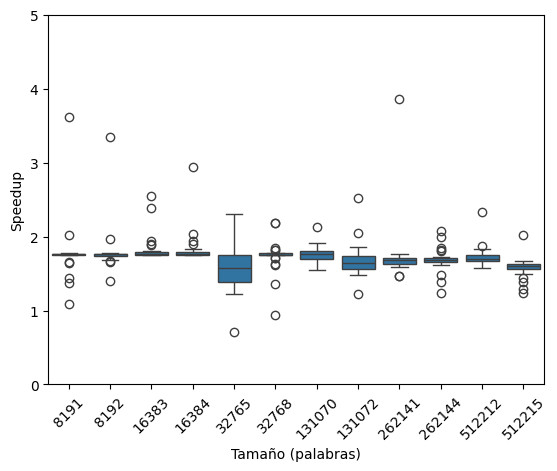

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df0 = pd.read_csv("dotproductdataO0.txt", sep=" ")
for c in df0.columns:
  df0[c] = pd.to_numeric(df0[c])

sns.boxplot(df0, x="tamaño", y="speedup")
plt.xlabel("Tamaño (palabras)")
plt.xticks(rotation=45)
plt.ylabel("Speedup");
plt.ylim([0,5])

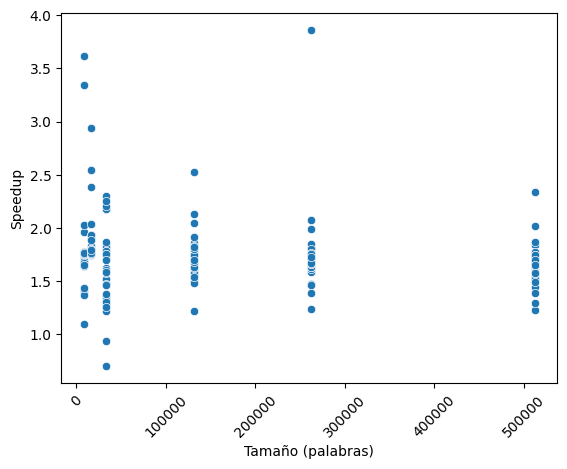

In [ ]:
sns.scatterplot(df0, x="tamaño", y="speedup")
plt.xlabel("Tamaño (palabras)")
plt.xticks(rotation=45)
plt.ylabel("Speedup");

(0.0, 5.0)

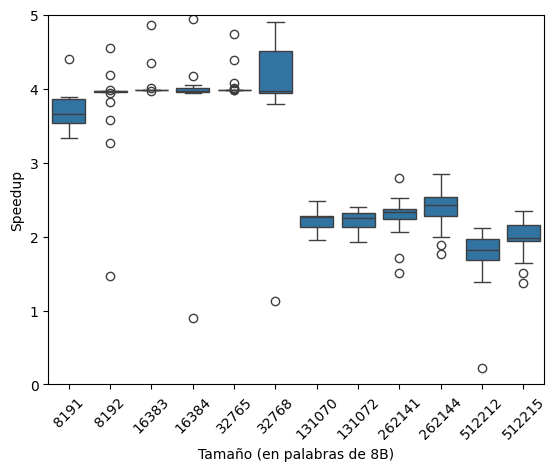

In [ ]:
df3 = pd.read_csv("dotproductdataO3.txt", sep=" ")

sns.boxplot(df3, x="tamaño", y="speedup")
plt.xlabel("Tamaño (en palabras de 8B)")
plt.xticks(rotation=45)
plt.ylabel("Speedup");
plt.ylim([0,5])


Comparación con diferentes niveles de optimización del compilador
Habilitar los diferentes niveles de optimización del compilador
(p. ej., -O1, -O2 y -O3). Compare los tiempos de ejecución de las diferentes versiones optimizadas según el nivel de optimización. ¿El código optimizado es más rápido? Si es así, ¿cuánto?

In [ ]:
df0["Opt"] = "O0"
df3["Opt"] = "O3"


df = pd.concat([df0, df3])

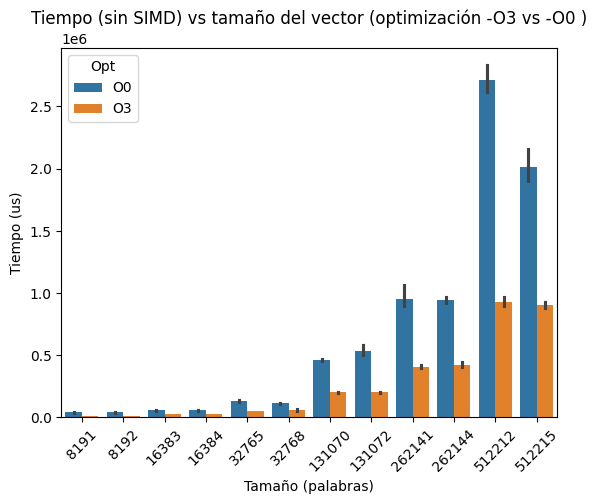

In [ ]:
sns.barplot(df, x="tamaño", y="time_naive", hue="Opt")
plt.title('Tiempo (sin SIMD) vs tamaño del vector (optimización -O3 vs -O0 )')
plt.xlabel('Tamaño (palabras)')
plt.ylabel('Tiempo (us)')
plt.xticks(rotation=45);

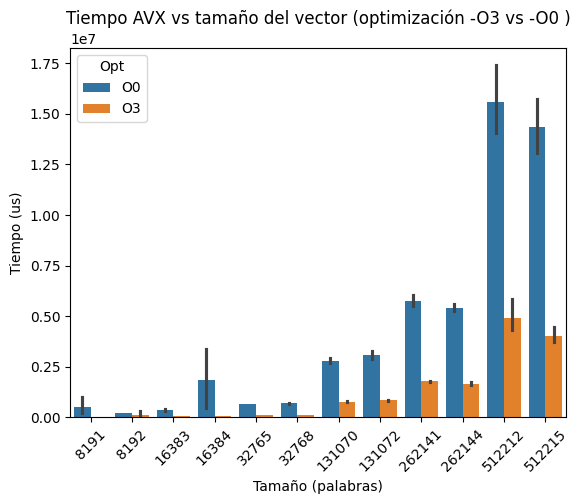

In [ ]:
sns.barplot(df, x="tamaño", y="time_simd", hue="Opt")
plt.title('Tiempo AVX vs tamaño del vector (optimización -O3 vs -O0 )')
plt.xlabel('Tamaño (palabras)')
plt.ylabel('Tiempo (us)')
plt.xticks(rotation=45);

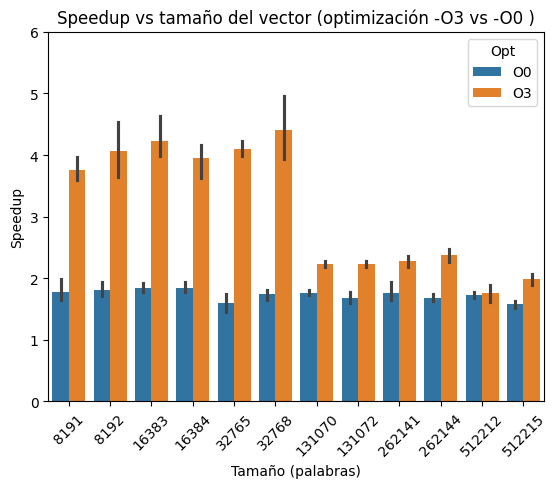

In [ ]:
sns.barplot(df, x="tamaño", y="speedup", hue="Opt")
plt.title('Speedup vs tamaño del vector (optimización -O3 vs -O0 )')
plt.xlabel('Tamaño (palabras)')
plt.ylabel('Speedup')
plt.xticks(rotation=45)
plt.ylim([0,6]);

## Ejercicio 3: Producto escalar de dos vectores con elementos floats de precisión simple ( 32 bit).

Basándose en el producto escalar de dos vectores con elementos reales (double de 64 bits), desarrolle y pruebe de manera similar el producto escalar de dos vectores con elementos cuyos valores son float de 32 bit (valores reales de coma flotante en precisión simple.

Al igual que en el tutorial debe realizar con criterio un estudio de la aceleración obtenida al vectorizar para diferentes tamaños de vector y comparar con resultados en un equipo de laborarorio o en su equipo personal, comentando los resultados obtenidos y destacando las principales diferencias observadas.